In [8]:
!pip install imbalanced-learn
!pip install shap

In [9]:
#Libraries

import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from scipy.stats import uniform, randint

#smote
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#Grid search
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [10]:
df = pd.read_excel(r'C:\Users\Jose Chua\OneDrive\Python\School Snek Work\831\Team_Project\cleaned2.xlsx')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   duration_of_dcp                              3122 non-null   int64  
 1   DCP_drop_status                              3122 non-null   int64  
 2   age_at_activation                            3122 non-null   int64  
 3   dependents_at_activation                     3122 non-null   int64  
 4   number_in_household_at_activation            3122 non-null   int64  
 5   asset_amount_owed_at_activation              3122 non-null   int64  
 6   asset_value_at_activation                    3122 non-null   int64  
 7   monthly_income_at_activation                 3122 non-null   float64
 8   monthly_expenses_at_activation               3122 non-null   float64
 9   DCP_debt_at_activation                       3122 non-null   int64  
 10  

In [12]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [13]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [14]:
#XGBoost

X = df.drop(columns=['DCP_drop_status'])
y = df['DCP_drop_status']

#training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

#evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

[[320  40]
 [ 47 218]]
Accuracy: 0.86
Precision: 0.84
Recall: 0.82
F1 Score: 0.83
AUC-ROC: 0.93


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       360
           1       0.84      0.82      0.83       265

    accuracy                           0.86       625
   macro avg       0.86      0.86      0.86       625
weighted avg       0.86      0.86      0.86       625



<Figure size 1500x1000 with 0 Axes>

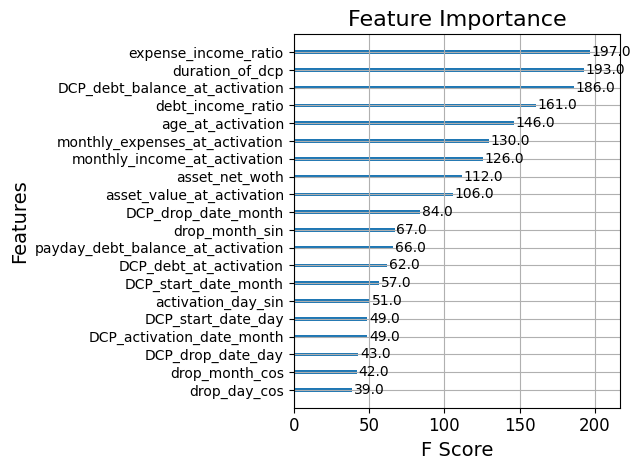

In [16]:
#feature importance

plt.figure(figsize=(15, 10))  # Adjust the size (width, height)

# Plot the feature importance
plot_importance(xgb_model, max_num_features=20, importance_type='weight', xlabel="F score")

# Adjust font size for better readability
plt.title("Feature Importance", fontsize=16)
plt.xlabel("F Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()  # Automatically adjust subplots to fit the figure area
plt.show()

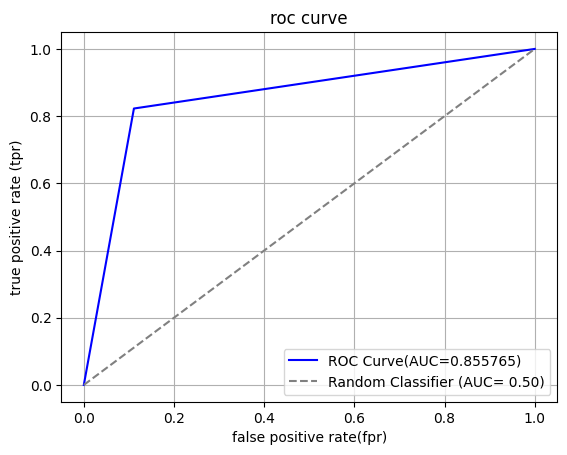

In [17]:
#auc curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = roc_auc_score(y_test,y_pred)

plt.figure()
plt.plot(fpr,tpr,color='blue',label=f'ROC Curve(AUC={roc_auc:2f})')
plt.plot([0,1],[0,1],color='gray',linestyle = '--',label='Random Classifier (AUC= 0.50)')
plt.xlabel('false positive rate(fpr)')
plt.ylabel('true positive rate (tpr)')
plt.title('roc curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [18]:
#checking balance 
print(y.value_counts(normalize=True))  # Proportion of each class

DCP_drop_status
0    0.605701
1    0.394299
Name: proportion, dtype: float64


In [19]:
#trying to balance the data
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: DCP_drop_status
0    1531
1     966
Name: count, dtype: int64
After SMOTE: DCP_drop_status
0    1531
1    1531
Name: count, dtype: int64


In [20]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)

# Train the model on the resampled data
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [21]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       360
           1       0.86      0.84      0.85       265

    accuracy                           0.88       625
   macro avg       0.87      0.87      0.87       625
weighted avg       0.87      0.88      0.88       625

Confusion Matrix:
[[324  36]
 [ 42 223]]


In [22]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Precision: 0.86
Recall: 0.84
F1 Score: 0.85
AUC-ROC: 0.93


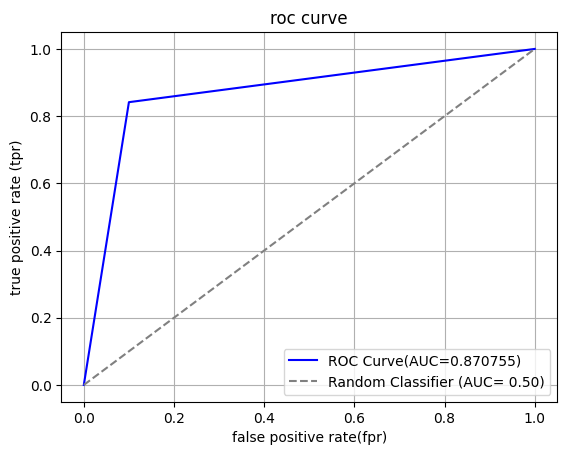

In [23]:
#auc curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = roc_auc_score(y_test,y_pred)

plt.figure()
plt.plot(fpr,tpr,color='blue',label=f'ROC Curve(AUC={roc_auc:2f})')
plt.plot([0,1],[0,1],color='gray',linestyle = '--',label='Random Classifier (AUC= 0.50)')
plt.xlabel('false positive rate(fpr)')
plt.ylabel('true positive rate (tpr)')
plt.title('roc curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

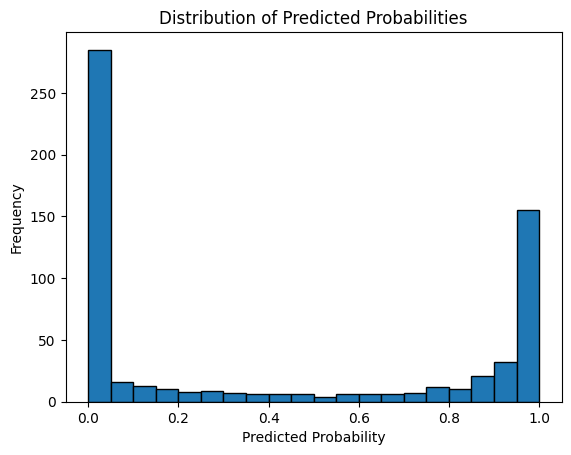

In [24]:
import matplotlib.pyplot as plt

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
plt.hist(y_pred_proba, bins=20, edgecolor="k")
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

<Figure size 1500x1000 with 0 Axes>

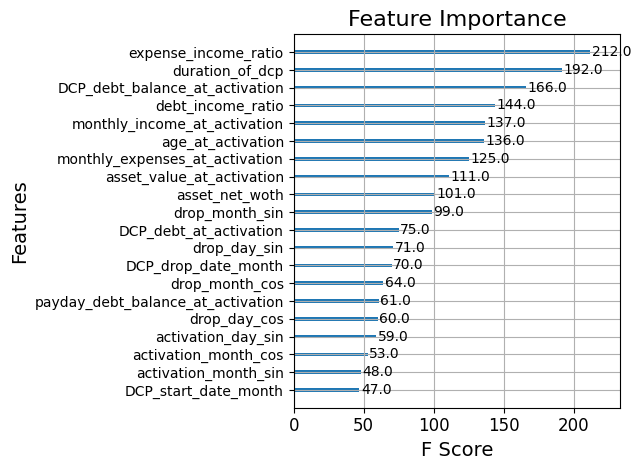

In [25]:
#feature importance

plt.figure(figsize=(15, 10))  # Adjust the size (width, height)

# Plot the feature importance
plot_importance(xgb_model, max_num_features=20, importance_type='weight', xlabel="F score")

# Adjust font size for better readability
plt.title("Feature Importance", fontsize=16)
plt.xlabel("F Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()  # Automatically adjust subplots to fit the figure area
plt.show()

In [26]:
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Predict binary labels
y_pred = xgb_model.predict(X_test)  # Default threshold is 0.5

# Evaluate metrics
print(classification_report(y_test, y_pred))  # Includes precision, recall, F1 for each class

# Calculate AUC-ROC for class 1
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC for Class 1: {auc:.2f}")

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       360
           1       0.86      0.84      0.85       265

    accuracy                           0.88       625
   macro avg       0.87      0.87      0.87       625
weighted avg       0.87      0.88      0.88       625

AUC-ROC for Class 1: 0.93
